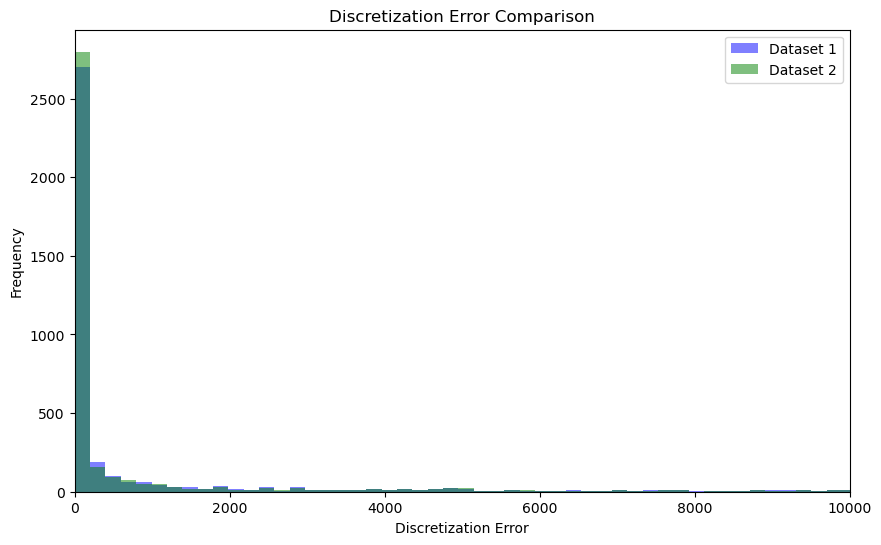

In [61]:
import numpy as np
from utils import helpers as h
from utils import settings as s
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset -> Hoerl
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241213_203958\location_assignment_result_load_main_hoerl_1000iters_1mgoal.csv')
Data1.df = Data1.df[Data1.df['to_location'].notna()]
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset -> Advanced Petre
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241218_154414\location_assignment_result_load_main_advanced_petre_100-branches_20-min-cand-two-leg_10-min-cand-complex.csv')
Data2.df = Data2.df[Data2.df['to_location'].notna()]
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_point)
Data2.evaluate_distance_deviations_from_df()

# Ensure the maximum value is limited to 1000
# Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
# Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)

# Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.legend()

plt.show()


In [62]:
# Sum up discretization errors for each person
hoerl_errors = Data1.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
hoerl_errors.rename(columns={'discretization_error': 'hoerl_error'}, inplace=True)

advanced_petre_errors = Data2.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
advanced_petre_errors.rename(columns={'discretization_error': 'advanced_petre_error'}, inplace=True)

# Merge the summed errors for comparison
merged_df = hoerl_errors.merge(advanced_petre_errors, on='unique_person_id')

# Add the error ratio column
merged_df['error_ratio'] = merged_df['advanced_petre_error'] / merged_df['hoerl_error']

# Filter for cases where advanced Petre has a higher error than Hoerl
worse_cases = merged_df[merged_df['advanced_petre_error'] > merged_df['hoerl_error']]
worse_cases = worse_cases.sort_values(by='error_ratio', ascending=False)

# Filter for cases where advanced Petre has a lower error than Hoerl
better_cases = merged_df[merged_df['advanced_petre_error'] < merged_df['hoerl_error']]
better_cases = better_cases.sort_values(by='error_ratio')

# Filter for cases where advanced Petre and Hoerl have equal errors
equal_cases = merged_df[merged_df['advanced_petre_error'] == merged_df['hoerl_error']]

print(f"Better cases: {len(better_cases)}")
print(f"Worse cases: {len(worse_cases)}")
print(f"Equal cases: {len(equal_cases)}")

worse_cases
# # Save the results
# worse_cases.to_csv('worse_cases.csv', index=False)
# better_cases.to_csv('better_cases.csv', index=False)
# equal_cases.to_csv('equal_cases.csv', index=False)

Better cases: 289
Worse cases: 1
Equal cases: 710


,unique_person_id,hoerl_error,advanced_petre_error,error_ratio
654,10483460_12014_10483461,3040.629074,3044.683401,1.001333


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [58]:
from analysis import plotting
plotting.plot_person_plan("10483460_12014_10483461", Data1.df, Data2.df)

In [63]:
Data1.df['discretization_error'].describe()

count     3728.000000
mean       883.897471
std       2298.198616
min          0.016113
25%          6.681718
50%         29.891386
75%        287.772541
max      19800.000000
Name: discretization_error, dtype: float64

In [64]:
Data2.df['discretization_error'].describe()


count     3728.000000
mean       777.149761
std       2116.774266
min          0.016987
25%          5.042955
50%         19.019695
75%        194.883487
max      19800.000000
Name: discretization_error, dtype: float64

In [14]:
# Filter df for a specific person
person_id = '10569980_12094_10569982'
person_df1 = Data1.df[Data1.df['unique_person_id'] == person_id]
person_df2 = Data2.df[Data2.df['unique_person_id'] == person_id]
person_df2

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,to_act_name,from_location,to_location,to_act_identifier,placed_distance,discretization_error
2822,10569980,0.581777,152.354841,2,2,1,0,2,4,4,...,0.0,0.0,work,[ 553853.81890119 5806435.19546441],['nan'],POINT (553853.81890119 5806435.19546441),POINT (553128.62764329 5801755.37139547),['28587009'],4735.679009,14.320991
2823,10569980,0.581777,152.354841,2,2,1,0,2,4,4,...,0.0,0.0,shopping,[ 553853.81890119 5806435.19546441],NaN,POINT (553128.62764329 5801755.37139547),POINT (554153.91895893 5803517.84069659),['85597744'],2038.999833,1748.999833
2824,10569980,0.581777,152.354841,2,2,1,0,2,4,4,...,0.0,0.0,leisure,[ 553853.81890119 5806435.19546441],NaN,POINT (554153.91895893 5803517.84069659),POINT (553853.81890119 5806435.19546441),NaN,2932.749373,1982.749373


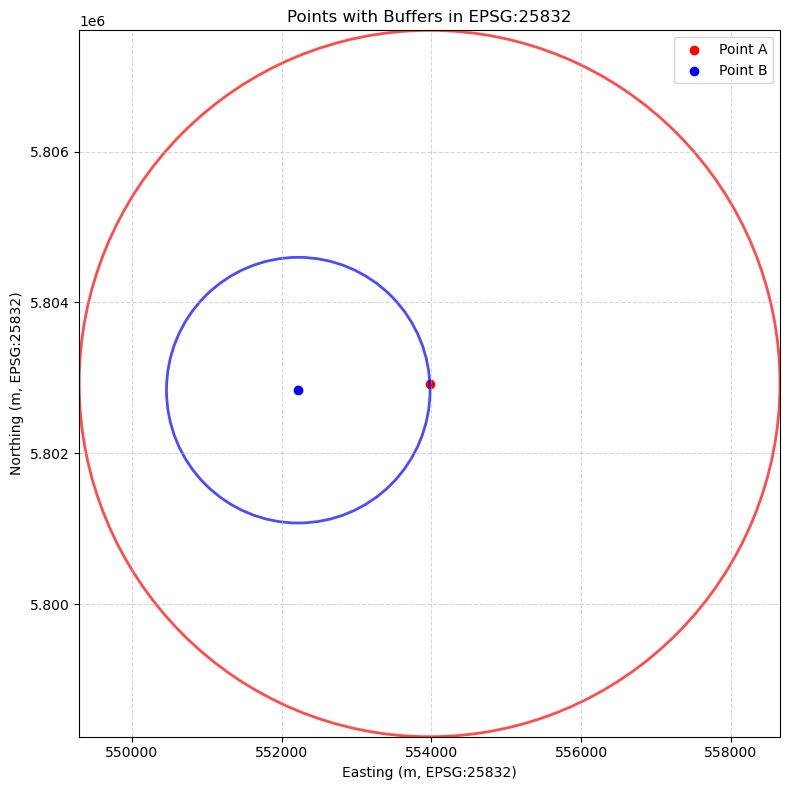

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Given coordinates and radii
xA, yA = 553974.57860439, 5802925.60509337
xB, yB = 552220.91668614, 5802837.50039429

radius_A = 4680.0
radius_B = 1760.0

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the points
ax.scatter([xA], [yA], color='red', label='Point A')
ax.scatter([xB], [yB], color='blue', label='Point B')

# Add circles (buffers) around the points
circleA = Circle((xA, yA), radius=radius_A, edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
circleB = Circle((xB, yB), radius=radius_B, edgecolor='blue', facecolor='none', linewidth=2, alpha=0.7)
ax.add_patch(circleA)
ax.add_patch(circleB)

# Adjust the plot view so both points and circles are visible
# Determine min and max extents by considering the outer boundaries of the largest circle
min_x = min(xA - radius_A, xB - radius_B)
max_x = max(xA + radius_A, xB + radius_B)
min_y = min(yA - radius_A, yB - radius_B)
max_y = max(yA + radius_A, yB + radius_B)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Add grid and legend for clarity
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Add labels
ax.set_xlabel('Easting (m, EPSG:25832)')
ax.set_ylabel('Northing (m, EPSG:25832)')
ax.set_title('Points with Buffers in EPSG:25832')

# Show the plot
plt.tight_layout()
plt.show()


In [41]:
Mid=pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\data\mid\enhanced\enhanced_mid.csv")
# show the col km_routing and wegkm_imp
# Mid = Mid[Mid['etapkm'] < 1000]
Mid[['km_routing', 'wegkm','wegkm_imp', 'etapkm', 'W_ZWECK', 'hvm']]

,km_routing,wegkm,wegkm_imp,etapkm,W_ZWECK,hvm
0,216.420,0.95,0.95,10107.0,4.0,4.0
1,216.419,1.43,1.43,10107.0,8.0,4.0
2,9995.000,10.45,10.45,10107.0,7.0,4.0
3,9995.000,7.60,7.60,10107.0,8.0,4.0
4,9995.000,13.30,13.30,10107.0,4.0,4.0
...,...,...,...,...,...,...
957009,70706.000,0.98,0.98,10107.0,1.0,2.0
957010,70706.000,0.98,0.98,10107.0,4.0,2.0
957011,70706.000,0.98,0.98,10107.0,8.0,2.0
957012,24.906,18.00,18.00,10107.0,7.0,5.0
